## sprint19課題 セグメンテーション2
この課題の目的    
・公開されている実装を動かす際のノウハウを得る    
・論文で読んだ手法を大規模なデータに適用する     
・過学習を抑制する手法を学ぶ   

【目的としないこと】   
高い精度を出す

In [1]:
from model import *
from data import *

Using TensorFlow backend.


## Train your Unet with membrane data
membrane data is in folder membrane/, it is a binary classification task.

The input shape of image and mask are the same :(batch_size,rows,cols,channel = 1)

### Train with data generator

In [ ]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'train','images','masks',data_gen_args,save_to_dir = None)
model = unet()
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=2000,epochs=5,callbacks=[model_checkpoint])

/Users/andoutakaaki/DIC_study/sprint18/unet-master/model.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


Epoch 1/5
Found 4000 images belonging to 1 classes.
Found 4000 images belonging to 1 classes.
1234/2000 [=================>............] - ETA: 4:06:23 - loss: 0.5200 - acc: 0.7691 

### segmentation_models/segmentation_models/unet/model.pyを見に行く

from .builder import build_unet
from ..utils import freeze_model
from ..backbones import get_backbone


DEFAULT_SKIP_CONNECTIONS = {
    'vgg16':            ('block5_conv3', 'block4_conv3', 'block3_conv3', 'block2_conv2', 'block1_conv2'),
    'vgg19':            ('block5_conv4', 'block4_conv4', 'block3_conv4', 'block2_conv2', 'block1_conv2'),
    'resnet18':         ('stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0'), # check 'bn_data'
    'resnet34':         ('stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0'),
    'resnet50':         ('stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0'),
    'resnet101':        ('stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0'),
    'resnet152':        ('stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0'),
    'resnext50':        ('stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0'),
    'resnext101':       ('stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0'),
    'inceptionv3':          (228, 86, 16, 9),
    'inceptionresnetv2':    (594, 260, 16, 9),
    'densenet121':          (311, 139, 51, 4),
    'densenet169':          (367, 139, 51, 4),
    'densenet201':          (479, 139, 51, 4),
}


def Unet(backbone_name='vgg16',
         input_shape=(None, None, 3),
         input_tensor=None,
         encoder_weights='imagenet',
         freeze_encoder=False,
         skip_connections='default',
         decoder_block_type='upsampling',
         decoder_filters=(256,128,64,32,16),
         decoder_use_batchnorm=True,
         n_upsample_blocks=5,
         upsample_rates=(2,2,2,2,2),
         classes=1,
         activation='sigmoid'):
    """
    Args:
        backbone_name: (str) look at list of available backbones.
        input_shape:  (tuple) dimensions of input data (H, W, C)
        input_tensor: keras tensor
        encoder_weights: one of `None` (random initialization), 'imagenet' (pre-training on ImageNet)
        freeze_encoder: (bool) Set encoder layers weights as non-trainable. Useful for fine-tuning
        skip_connections: if 'default' is used take default skip connections,
            else provide a list of layer numbers or names starting from top of model
        decoder_block_type: (str) one of 'upsampling' and 'transpose' (look at blocks.py)
        decoder_filters: (int) number of convolution layer filters in decoder blocks
        decoder_use_batchnorm: (bool) if True add batch normalisation layer between `Conv2D` ad `Activation` layers
        n_upsample_blocks: (int) a number of upsampling blocks
        upsample_rates: (tuple of int) upsampling rates decoder blocks
        classes: (int) a number of classes for output
        activation: (str) one of keras activations for last model layer
    Returns:
        keras.models.Model instance
    """



    backbone = get_backbone(backbone_name,
                            input_shape=input_shape,
                            input_tensor=input_tensor,
                            weights=encoder_weights,
                            include_top=False)

    if skip_connections == 'default':
        skip_connections = DEFAULT_SKIP_CONNECTIONS[backbone_name]

    model = build_unet(backbone,
                       classes,
                       skip_connections,
                       decoder_filters=decoder_filters,
                       block_type=decoder_block_type,
                       activation=activation,
                       n_upsample_blocks=n_upsample_blocks,
                       upsample_rates=upsample_rates,
                       use_batchnorm=decoder_use_batchnorm)

    # lock encoder weights for fine-tuning
    if freeze_encoder:
        freeze_model(backbone)

    model.name = 'u-{}'.format(backbone_name)

    return model

### Image segmentationにおけるデータ前処理についての考察ノート

In [1]:
import gc
import glob
import os
import matplotlib.pyplot as plt

import cv2
import numpy as np
import pandas as pd

from tensorflow.keras.callbacks import *
from tensorflow.keras.models import load_model
from tqdm import tqdm

from sklearn.model_selection import train_test_split

%matplotlib inline

#### Load data:

いつものように、私たちはデータの読み込みと構造の素早い検討から始めます。 ここでは、訓練DFと試験DFは非常に簡単です。 訓練が設定されている場合、各画像IDとそのマスクに関する情報が与えられます。 DFでは、マスクの座標は競合評価ページに従って、ピクセル値に対するRLE（ランレングス符号化）を使用して符号化される。 提出は同様の方法で準備する必要があり、マスクはRLE形式にエンコードする必要があります。

この大会では、各写真に深さに関する情報も提供されています。 これはモデリングの目的に役立つかもしれません。そのため、トレーニングとテストのデータセットと統合する必要があります。

In [2]:
plt.rcParams['figure.figsize'] = (12, 9)
# plt.style.use('ggplot')

#### Depth:

深さ分布を見てみましょう。


In [3]:
train = pd.read_csv('/Users/andoutakaaki/DIC_study/sprint18/unet-master/train.csv')
test = pd.read_csv('/Users/andoutakaaki/DIC_study/sprint18/unet-master/sample_submission.csv')
depth = pd.read_csv('/Users/andoutakaaki/DIC_study/sprint18/unet-master/depths.csv')


train_src = '/Users/andoutakaaki/DIC_study/sprint18/unet-master/train/images'
train_mask = '/Users/andoutakaaki/DIC_study/sprint18/unet-master/train/masks'

print('train:\n{}'.format(train.head()))
print('\ntest:\n{}'.format(test.head()))

train:
           id                                           rle_mask
0  575d24d81d                                                NaN
1  a266a2a9df                                          5051 5151
2  75efad62c1  9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3  34e51dba6a  48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4  4875705fb0  1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...

test:
           id rle_mask
0  155410d6fa      1 1
1  78b32781d1      1 1
2  63db2a476a      1 1
3  17bfcdb967      1 1
4  7ea0fd3c88      1 1


#### Trainに参加し、奥行き情報を持つデータをテストする：

この場合、深度データの統合は非常に簡単です。 TrainとTestのDataFramesにIDで簡単にマージすることができます。

count    22000.000000
mean       506.453318
std        208.605991
min         50.000000
25%        352.000000
50%        513.000000
75%        671.000000
max        959.000000
Name: z, dtype: float64


(array([ 62.,  70.,  61., 101., 139., 110., 144., 137., 132., 120., 138.,
        137., 119., 137., 147., 149., 139., 158., 174., 172., 184., 170.,
        201., 191., 221., 194., 213., 245., 251., 257., 233., 256., 266.,
        286., 257., 279., 293., 299., 305., 287., 277., 313., 294., 321.,
        373., 314., 330., 316., 341., 344., 344., 310., 360., 329., 342.,
        380., 332., 299., 352., 297., 319., 324., 320., 303., 308., 279.,
        318., 263., 307., 288., 287., 272., 268., 273., 241., 285., 259.,
        268., 209., 249., 225., 226., 226., 245., 209., 196., 203., 224.,
         84.,  41.,  51.,  54.,  46.,  42.,  34.,  46.,  40.,  47.,  63.,
         56.]),
 array([ 50.  ,  59.09,  68.18,  77.27,  86.36,  95.45, 104.54, 113.63,
        122.72, 131.81, 140.9 , 149.99, 159.08, 168.17, 177.26, 186.35,
        195.44, 204.53, 213.62, 222.71, 231.8 , 240.89, 249.98, 259.07,
        268.16, 277.25, 286.34, 295.43, 304.52, 313.61, 322.7 , 331.79,
        340.88, 349.97, 359.06

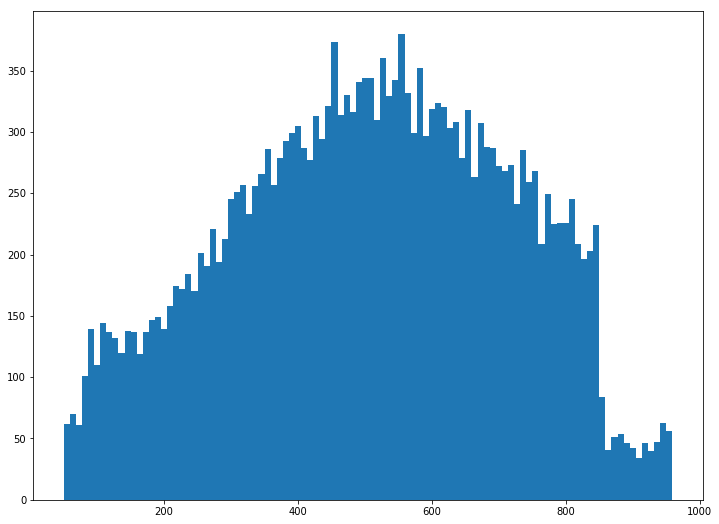

In [4]:
print(depth.z.describe())

plt.hist(depth.z, bins=100)

#### Data examination:

私たちがここで扱っているデータについてより良いフィーリングを得るために、画像とそのマスクを視覚化してみましょう。

いくつかのランダムな例を可視化した後、wenはtrain列のrle_mask列がNaNである場合、マスクが空であることを示します。

In [5]:
train = train.merge(depth, how='left', on='id')
test = test.merge(depth, how='left', on='id')

print('\n{}'.format(train.head()))


           id                                           rle_mask    z
0  575d24d81d                                                NaN  843
1  a266a2a9df                                          5051 5151  794
2  75efad62c1  9 93 109 94 210 94 310 95 411 95 511 96 612 96...  468
3  34e51dba6a  48 54 149 54 251 53 353 52 455 51 557 50 659 4...  727
4  4875705fb0  1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...  797


In [6]:
# # Choose random index to visualize a random sample
# random_index = np.random.randint(0, train.shape[0])


# img_ = cv2.imread(train_src + 'images/{}.png'.format(train['id'][random_index]))
# mask_ = cv2.imread(train_mask + 'masks/{}.png'.format(train['id'][random_index]), 0)
# print(train.iloc[random_index, :])


# fig, ax = plt.subplots(1, 2)
# ax[0].set_title('index: {}, depth: {}'.format(
#     random_index, train['z'][random_index]))
# ax[0].imshow(img_)
# ax[1].imshow(mask_, cmap='gray')

### 説明課題

### 過学習の抑制について
・正規化（normalization）とは、機械学習モデルが学習する様々なサンプルの類似度を高めることで、モデルが新しいデータを学習したときにうまく汎化できるようにすることを目的とした、幅広い手法のこと。Batch Normalization（Kerasにおけるバッチ正規化）は、2015年にIoffeとSzegedyによって提唱された層の一種。この層では、訓練中に平均と分散が変化するとしても、データを適応的に正規化できる。バッチ正規化は、バッチごとのデータの平均と分散の指数移動平均を内部で維持する、という仕組みになっている。バッチ正規化の主な効果は、（残差接続と同様に）勾配の伝播を手助けすること。それにより、過学習を抑制し、さらに深いネットワークの訓練が可能になる。     
・その他過学習を抑制する手法については、まず、学習データの数を増やすことがあげられる。学習データの数が多ければ多いほど、学習（訓練）データのバリエーションが増えていき、未知のデータに近づいていく。また、ネットワーク自由度を強制的に小さくして過学習を避ける方法としてドロップアウトがある。多層ネットワークの各層のユニットを確率的に選別して、選別したもの以外を無効化することで、自由度の小さい仮のネットワークができる。その上で学習させることでモデルを簡素化したような効果が得られる。今回は、データの数が多かったのに加え、ドロップアウトやBatch Normalizationもコードの中に含まれている。      



### 転移学習とファインチューニングについて
・転移学習は、既存の学習済モデル（出力層以外の部分）を、重みデータは変更せずに特徴量抽出機として利用する。一方で、ファインチューニングは、既存の学習済モデル（出力層以外の部分）を、重みデータを一部再学習して特徴量抽出機として利用する。     
・ImageNetは、ディープラーニングが台頭するきっかけとなった事前学習モデルである。このデータセットは、1,000種類の画像カテゴリ（画像ごとに1カテゴリ）にアノテーション情報（犬や猫などのカテゴリ名や物体の位置などの正解情報）がついた140万枚の画像で構成され、カテゴリのバリエーション、クラス内のバリエーションが豊富。これにより、一般物体認識だけでなく、物体検出のデータセットとしても活用してすることができる。この学習データセットを用いた物体認識のコンペティションとしてImageNet Large Scale Visual Recognition Challenge(LSVRC)というコンペを毎年開催している。     
・事前学習モデルの選び方については、大量の学習サンプル用のデータがあるのが良い。大量の学習サンプルをひとまとめにしたデータセットがあれば、それを用いて学習することができる。一方、限られたデータ量しか用意していないデータセットの場合などは、限られたデータを最大限有効に使うデータ拡張が有効な手段の一つである。